# Notebook for the preprocessing of the audio files

The preprocessing consists of the following steps:
1. Read in files
2. Resample files to standardized sampling rate (e.g. 32000kHz)
3. Draw clip of specific length from audio
    - pad short clips with silence
    - draw clip from random index of audio
4. Compute log mel spectrogram of clip
5. Rescale (MinMax Scaler / Standard scaler?)

Due to the large amounts of data this needs to be done using a generator function/class.

## Additional steps for the kNN

- Apply Lomb-Scargle / FFT
- Extract meaningful audio features
- Save information to df

## Issues

- slow as heck, even on low data
    - "process_file" function itself is very slow
- every file is read again for every epoch, every time the spectrogram is calculated again
- eats more RAM than 100 google tabs
- audios are not very clean, other birds in background, empty sequences
- Error (don't know if important): 
        Note: Illegal Audio-MPEG-Header 0x1c020000 at offset 273280.
        Note: Trying to resync...
        Note: Hit end of (available) data during resync.
- poor accuracy
- rescaling is not correct, I think

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

from pathlib import Path
import sys
import os
import time
from tqdm import tqdm
import warnings
# suppress all warnings
warnings.filterwarnings("ignore")

XC_ROOTDIR = '../../data/' # directory to save data in
XC_DIR = 'test_dataset10' # subdirectory name of dataset

In [2]:
#!pip install tensorflow[and-cuda]==2.14

### Check if tensorflow can use GPU

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-06-12 19:57:02.910591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 19:57:02.910657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 19:57:02.911822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 19:57:02.918605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 19:57:03.730754: W tensorflow/compiler/tf2

Num GPUs Available:  1


2024-06-12 19:57:04.513442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 19:57:04.540347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 19:57:04.540754: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Read dataframe

In [4]:
df = pd.read_csv(XC_ROOTDIR + 'dataset10.csv', index_col = 0)
df["fullfilename"] = "../" + df["fullfilename"]
df.head(2)

,sp,ssp,group,en,rec,cnt,loc,lat,lng,alt,...,playback-used,temp,regnr,auto,dvc,mic,smp,nr other,length_seconds,fullfilename
gen,,,,,,,,,,,,,,,,,,,,,
Turdus,merula,NaN,birds,Common Blackbird,Beatrix Saadi-Varchmin,Germany,"Bad Endorf (near Rosenheim)), Oberbayern, Bayern",47.9075,12.2896,550,...,no,NaN,NaN,no,NaN,NaN,44100,1,299,../../data/dataset10/Turdus merula_Common Blac...
Turdus,merula,NaN,birds,Common Blackbird,Ireneusz Oleksik,Poland,"ROD Browarnik (near Tychy), Tychy, śląskie",50.1329,18.9570,260,...,no,NaN,NaN,no,NaN,NaN,48000,1,297,../../data/dataset10/Turdus merula_Common Blac...


## For testing purposes only 10 classes will be used here

In [5]:
len(df)

300

In [6]:
species = np.unique(df["en"])
species[:10]
df = df[df["en"].apply(lambda x: x in species[:10])]
len(df)

300

## Config class

In [7]:
class Config():
    def __init__(self, window = 10, sr = 22050, nfft = 2*2048, hop_length = 4*512, n_mels = 64, n_classes = 10):
        self.window = window
        self.sr = sr
        self.nfft = nfft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.n_classes = n_classes
        
config = Config()

## Build function to process file to log mel spectrogram

In [8]:
def process_file(filepath, 
                 sr = config.sr, window = config.window, nfft = config.nfft, hop_length = config.hop_length, 
                 n_mels = config.n_mels, fmax = config.sr/2, return_audio = False):
    
    audio, sr = librosa.load(filepath, sr = sr)
    
    # Chose random clip from audiofile
    if len(audio) < window*sr: # randomly pad clip if shorter
        _ = np.zeros(window*sr)
        rand_idx = np.random.randint(0, window*sr-len(audio))
        _[rand_idx:rand_idx + len(audio)] = audio
        audio = _
    else: # select random window if clip longer
        rand_idx = np.random.randint(0, len(audio) - window*sr)
        audio = audio[rand_idx:rand_idx + window*sr]
    
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=nfft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    if return_audio:
        return log_mel_spectrogram, audio
    return log_mel_spectrogram

### Test the processing function

In [9]:
idx = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270]
files, labels = [], []
for i in idx:
    files.append( df.iloc[i].fullfilename)
    labels.append(df.iloc[i].en)

In [10]:
labels

['Common Blackbird',
 'European Robin',
 'Great Tit',
 'Eurasian Blackcap',
 'Common Chaffinch',
 'Eurasian Wren',
 'Song Thrush',
 'Common Chiffchaff',
 'Common Nightingale',
 'Common Cuckoo']

In [11]:
specs = []
audios = []
for i in tqdm(range(len(idx))):
    spec, audio = process_file(files[i], return_audio = True)
    specs.append(spec)
    audios.append(audio)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.91s/it]


In [12]:
Audio(data = audios[5], rate = config.sr)

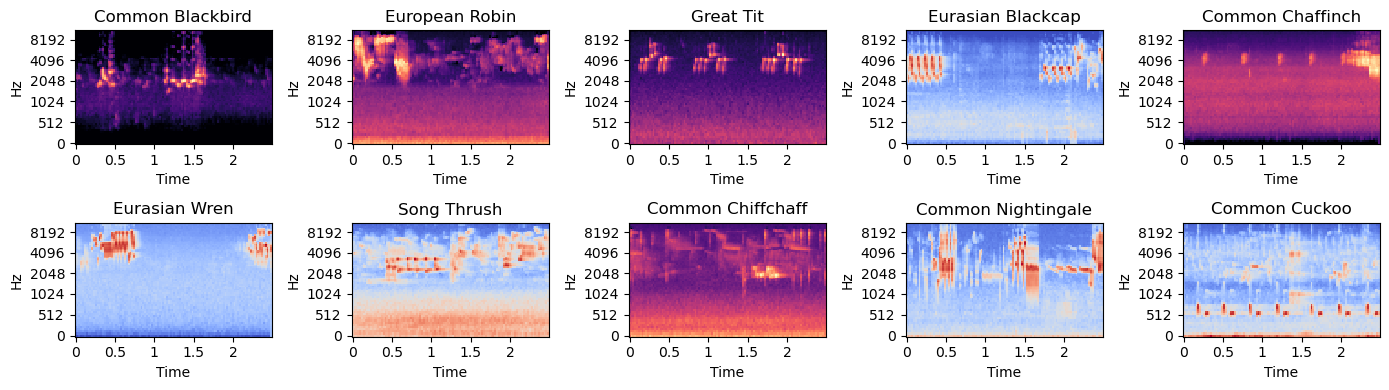

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, figsize = (14, 4))

for i in range(len(idx)):
    ax[i//5, i%5].set_title(labels[i])
    librosa.display.specshow(specs[i], sr = config.sr, x_axis = "time", y_axis = "mel", ax = ax[i//5, i%5])
    plt.tight_layout()

In [14]:
specs[0].shape

(64, 108)

In [15]:
int(config.window*config.sr/config.hop_length)

107

# Build generator

In [16]:
label = {
    'Common Blackbird': 0,
     'European Robin': 1,
     'Great Tit': 2,
     'Eurasian Blackcap': 3,
     'Common Chaffinch': 4,
     'Eurasian Wren': 5,
     'Song Thrush': 6,
     'Common Chiffchaff': 7,
     'Common Nightingale': 8,
     'Common Cuckoo': 9
}

import keras
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=16, 
                 dim=(config.n_mels, int(config.window*config.sr/config.hop_length) + 1),
                 n_channels =  1,
                 n_classes=config.n_classes, shuffle=True):
        'Initialization'
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        #_min, _max = float('inf'), -float('inf')
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = process_file(df.iloc[ID].fullfilename).reshape(*self.dim, self.n_channels)
            
            # Store class
            y[i] = label[df.iloc[ID].en]
        X = Scaler.fit_transform(X.reshape(len(X), -1).astype(np.float32))
        X = X.reshape(len(X), *self.dim, self.n_channels)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

# First test of very simple model

In [17]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

#model = Sequential()
#
input_shape = (config.n_mels, int(config.window*config.sr/config.hop_length) + 1, 1)
#
#model.add(Conv2D(16, kernel_size=(3, 3), padding='valid', activation='relu',
#                 input_shape=input_shape))
#model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
#model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
#model.add(Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
#model.add(Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'))
#model.add(Dropout(0.25))
#model.add(Flatten())
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(10, activation='softmax'))
#
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#
#model.summary()

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D

def build_model(input_shape, num_classes):
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
    
    # Second Convolutional Block
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
    
    # Third Convolutional Block
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
    
    # Fourth Convolutional Block
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
    
    # Fifth Convolutional Block
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
    
    # Global Average Pooling instead of Flatten
    model.add(GlobalAveragePooling2D())
    
    # Fully Connected Layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

model = build_model(input_shape, 10)
model.summary()

2024-06-12 19:57:46.635123: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 19:57:46.635870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 19:57:46.636333: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 19:57:46.801978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 19:57:46.802365: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 108, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 64, 108, 32)       128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 54, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 54, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 54, 64)        256       
 chNormalization)                                                
                                                        

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# Datasets
from sklearn.model_selection import train_test_split

id_train, id_val, y_train, y_val = train_test_split(range(300), df["en"].to_list(), test_size = 0.3, random_state = 4)

training_generator = DataGenerator(id_train, y_train)
validation_generator = DataGenerator(id_val, y_val)

# Fit model

In [ ]:
hist = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True, verbose = 2, epochs = 15)

Epoch 1/15


2024-06-12 19:59:27.855264: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-12 19:59:28.186529: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-12 19:59:29.080066: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-12 19:59:29.831124: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbc71c1d720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-12 19:59:29.831167: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2024-06-12 19:59:29.850780: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718215169.973011    2816 device_com

13/13 - 968s - loss: 3.4335 - accuracy: 0.1202 - val_loss: 2.3142 - val_accuracy: 0.0500 - 968s/epoch - 74s/step
Epoch 2/15


Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10036161.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10036161.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 5793876.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x6c202f2f at offset 4234262.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10021533.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10036161.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x6c202f2f at offset 4234262.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


13/13 - 846s - loss: 2.8664 - accuracy: 0.0913 - val_loss: 2.3328 - val_accuracy: 0.1500 - 846s/epoch - 65s/step
Epoch 3/15


Note: Illegal Audio-MPEG-Header 0x50455441 at offset 5793876.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10021533.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10036161.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10021533.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10036161.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 5793876.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x6c202f2f at offset 4234262.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x504

13/13 - 6994s - loss: 2.6589 - accuracy: 0.1346 - val_loss: 2.3882 - val_accuracy: 0.0875 - 6994s/epoch - 538s/step
Epoch 4/15


Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10036161.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10021533.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x6c202f2f at offset 4234262.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10036161.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x6c202f2f at offset 4234262.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 5793876.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 10021533.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x504

13/13 - 891s - loss: 2.6441 - accuracy: 0.0913 - val_loss: 2.3733 - val_accuracy: 0.1000 - 891s/epoch - 69s/step
Epoch 5/15
